In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

np.random.seed(2021)

data_loc = '/Users/simon/Documents/DTU/9. semester/deep learning/data'

df_all = []

files = os.listdir(os.path.join(data_loc,'modified data'))
for file in sorted(files):
    path = os.path.join(data_loc,'modified data',file)
    name, ext = os.path.splitext(file)
    if ext != '.csv':
        continue
    df = pd.read_csv(path)
    df.name = name
    
    for col_name in df.columns:
        if col_name != 'Date_Time':
            df[col_name]=df[col_name].astype('float64')
        else:
            df['Date_Time'] = pd.to_datetime(df['Date_Time'])
    
    df_all.append(df)
    print(name)

case=1

y = torch.Tensor(df_all[case-1]['Park Power [KW]'].values[:,None])
y_time = df_all[case-1]['Date_Time']
x = torch.Tensor(df_all[case+2].iloc[:,1:].values)
x_time = df_all[case+2]['Date_Time']

print(x.shape)
print(y.shape)

del df_all
del df

Measurement 1
Measurement 2
Measurement 3
NWP 1
NWP 2
NWP 3
torch.Size([182918, 16])
torch.Size([147205, 1])


In [2]:
# make sure all time differences are equal
assert x_time.diff().min()==x_time.diff().max()
assert y_time.diff().min()==y_time.diff().max()
assert x_time.diff().min()==y_time.diff().min()
# check that training and target data end at the same time
assert y_time.iloc[-1]==x_time.iloc[-1]

# Time difference between start of training and target data, and corresponding offset in indecies
time_dif = (y_time.iloc[0]-x_time.iloc[0])
idx_offset = time_dif.days*24*4+round(time_dif.seconds/(60*15))

# Index offset between start and end of training data for one single prediction
# i.e. number of quarters of an hour we wish to train on for each sample
idx_train_len = 3*4+1

#i=1000
#print(target_time[i])
#print(x_time[i+idx_offset-idx_train_len+1:i+idx_offset+1])

good_idx = []
for i in range(y.shape[0]):
    if not (torch.isnan(y[i]) or torch.any(torch.isnan(x[i+idx_offset-idx_train_len+1:i+idx_offset+1]))):
        good_idx.append(i)
good_idx = np.array(good_idx)

In [3]:
print(x.shape)
print(y.shape)
print(len(x_time))
print(len(y_time))
print(x_time[0])
print(y_time[0])
print(len(good_idx))

torch.Size([182918, 16])
torch.Size([147205, 1])
182918
147205
2016-01-01 20:00:00
2017-01-07 20:15:00
138861


In [4]:
input_size = x.shape[1]
hidden_size = 50
out_size = 1


# define network
class Net(nn.Module):

    def __init__(self, input_size, hidden_size, out_size):
        super(Net, self).__init__()  
        
        
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            batch_first=True, # batch_size x sequence_length x input_size
                            bias=True)
        self.act = nn.ReLU()
        self.l_out = nn.Linear(in_features=hidden_size,
                               out_features=out_size,
                               bias=False)
        
        
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x[:, -1, :]
        x = self.act(x)
        x = self.l_out(x)
        return x


net = Net(input_size, hidden_size, out_size)
print(net)

optimizer = optim.Adam(net.parameters())
loss = nn.MSELoss()

Net(
  (lstm): LSTM(16, 50, batch_first=True)
  (act): ReLU()
  (l_out): Linear(in_features=50, out_features=1, bias=False)
)


In [5]:
# setting hyperparameters and gettings epoch sizes
batch_size = 10000
num_epochs = 10

num_good = len(good_idx)
np.random.shuffle(good_idx)
k_fold_size = 5
in_valid_bool = np.zeros(num_good, dtype=bool)
in_train_bool = np.zeros(num_good, dtype=bool)


#use Stacked Cross-Validation for check appropriate dataset length
def get_stacked_cv_idx(k):
    in_valid_bool.fill(0)
    in_train_bool.fill(0)
    in_valid_bool[(1+k)*num_good//k_fold_size : (2+k)*num_good//k_fold_size] = 1
    in_train_bool[:(1+k)*num_good//k_fold_size] = 1
    valid_idx = good_idx[in_valid_bool]
    train_idx = good_idx[in_train_bool]
    return valid_idx, train_idx

def get_k_fold_cv_idx(k):
    in_valid_bool.fill(0)
    in_valid_bool[k*y.shape[0]//k_fold_size : (k+1)*y.shape[0]//k_fold_size] = 1
    in_train_bool = np.logical_not(in_valid_bool)
    valid_idx = good_idx[in_valid_bool]
    train_idx = good_idx[in_train_bool]
    return valid_idx, train_idx

def get_slice(batch_idx, batch_size): 
    return range(batch_idx * batch_size, (batch_idx + 1) * batch_size)

def get_x_sequences(idx, x_stacked):
    for i in range(len(idx)):
        x_stacked[i, :, :] = x[idx[i]+idx_offset-idx_train_len+1:idx[i]+idx_offset+1, :]
    x_stacked

fold=0
valid_idx, train_idx = get_k_fold_cv_idx(fold)

num_samples_train = train_idx.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = valid_idx.shape[0]
num_batches_valid = num_samples_valid // batch_size

x_input = torch.zeros(batch_size, idx_train_len, input_size)

# setting up lists for handling loss/accuracy
train_loss = []
valid_loss = []
cur_loss = 0

for epoch in range(num_epochs):
    ## Training
    # Forward -> Backprob -> Update params
    net.train()
    cur_loss = 0
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)

        get_x_sequences(train_idx[slce], x_input)
        
        output = net(x_input)

        # compute gradients given loss
        batch_loss = loss(output, y[train_idx[slce]])
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    train_loss.append(cur_loss.detach().numpy() / num_batches_train)

    ## Validation
    net.eval()
    cur_loss = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        get_x_sequences(valid_idx[slce], x_input)
        
        output = net(x_input)
        
        # compute gradients given loss
        batch_loss = loss(output, y[valid_idx[slce]])
        
        cur_loss += batch_loss   
    valid_loss.append(cur_loss.detach().numpy() / num_batches_valid)
        

    
    if epoch % (num_epochs//10) == 0:
        print("Epoch %2i : Train Loss %f , Valid Loss %f" % (
                epoch, train_loss[-1], valid_loss[-1]))

        

Epoch  0 : Train Loss 433486284.800000 , Valid Loss 433755232.000000
Epoch  1 : Train Loss 433480089.600000 , Valid Loss 433747648.000000
Epoch  2 : Train Loss 433470412.800000 , Valid Loss 433735168.000000
Epoch  3 : Train Loss 433455308.800000 , Valid Loss 433717504.000000
Epoch  4 : Train Loss 433436620.800000 , Valid Loss 433698624.000000
Epoch  5 : Train Loss 433418854.400000 , Valid Loss 433682304.000000
Epoch  6 : Train Loss 433402982.400000 , Valid Loss 433666816.000000
Epoch  7 : Train Loss 433388441.600000 , Valid Loss 433653856.000000
Epoch  8 : Train Loss 433376051.200000 , Valid Loss 433641792.000000
Epoch  9 : Train Loss 433364582.400000 , Valid Loss 433631616.000000


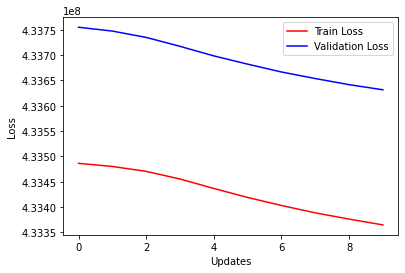

In [6]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', epoch, valid_loss, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')
plt.show()